In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Parameters
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 30

In [3]:
# Load CSVs
train_csv = pd.read_csv("Training_set.csv")
test_csv = pd.read_csv("Testing_set.csv")

In [4]:
train_csv.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [5]:
test_csv.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [6]:
# Add image paths
train_csv['filepath'] = 'train/' + train_csv['filename']
test_csv['filepath'] = 'test/' + test_csv['filename']

In [7]:
# Encode labels for training set only
label_encoder = LabelEncoder()
train_csv['label_enc'] = label_encoder.fit_transform(train_csv['label'])

In [8]:
# Load and preprocess training images
def load_images(filepaths, labels):
    images = []
    for fp in filepaths:
        img = load_img(fp, target_size=IMAGE_SIZE)
        img = img_to_array(img) / 255.0  # normalize
        images.append(img)
    return np.array(images), tf.keras.utils.to_categorical(labels)

In [9]:
# Load test images (no labels)
def load_images_test(filepaths):
    images = []
    for fp in filepaths:
        img = load_img(fp, target_size=IMAGE_SIZE)
        img = img_to_array(img) / 255.0
        images.append(img)
    return np.array(images)

In [10]:
# Load train data
X_train, y_train = load_images(train_csv['filepath'], train_csv['label_enc'])

In [11]:
# Load test data (optional usage — predictions only)
X_test = load_images_test(test_csv['filepath'])

In [12]:
# Train-validation split
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

In [13]:
# Build CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(*IMAGE_SIZE, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

c:\Users\sajee\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │        19,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,536,203 (24.93 MB)

 Trainable params: 6,535,755 (24.93 MB)

 Non-trainable params: 448 (1.75 KB)

In [15]:
# Train model
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.0284 - loss: 6.0858 - val_accuracy: 0.0221 - val_loss: 4.7553
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 364ms/step - accuracy: 0.0295 - loss: 4.2965 - val_accuracy: 0.0210 - val_loss: 4.4069
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 364ms/step - accuracy: 0.0369 - loss: 4.2269 - val_accuracy: 0.0538 - val_loss: 4.1302
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 364ms/step - accuracy: 0.0423 - loss: 4.1732 - val_accuracy: 0.0554 - val_loss: 4.1250
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 481ms/step - accuracy: 0.0439 - loss: 4.1995 - val_accuracy: 0.0349 - val_loss: 4.1640
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 472ms/step - accuracy: 0.0377 - loss: 4.1907 - val_accuracy: 0.0646 - val_loss: 3.9253
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 459ms/step - accuracy: 0.0505 - loss: 4.0975 - val_accuracy: 0.0549 - val_loss: 4.0386
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 59s 411ms/step - accuracy: 0.0448 - loss: 4

In [16]:
# Plot accuracy and loss
def plot_history(hist):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()


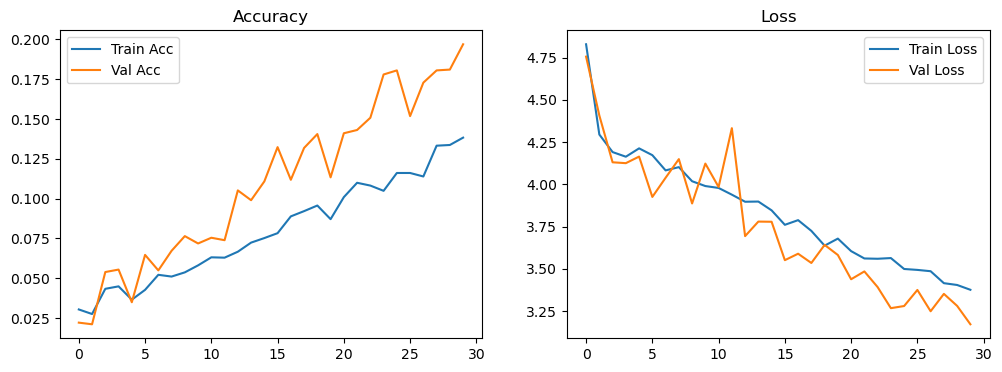

In [17]:
plot_history(history)


In [18]:
# Evaluate on validation set
val_preds = model.predict(X_val)
y_val_pred = np.argmax(val_preds, axis=1)
y_val_true = np.argmax(y_val, axis=1)

61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step


In [19]:
print("\nClassification Report (Validation Set):")
print(classification_report(y_val_true, y_val_pred, target_names=label_encoder.classes_))


Classification Report (Validation Set):
                           precision    recall  f1-score   support

                   ADONIS       0.62      0.78      0.69        23
AFRICAN GIANT SWALLOWTAIL       0.00      0.00      0.00        24
           AMERICAN SNOOT       0.00      0.00      0.00        19
                    AN 88       0.00      0.00      0.00        20
                  APPOLLO       0.30      0.61      0.40        28
                    ATALA       0.16      0.52      0.24        27
 BANDED ORANGE HELICONIAN       0.04      1.00      0.08        30
           BANDED PEACOCK       0.33      0.32      0.33        22
            BECKERS WHITE       0.00      0.00      0.00        29
         BLACK HAIRSTREAK       0.00      0.00      0.00        30
              BLUE MORPHO       0.38      0.24      0.29        21
        BLUE SPOTTED CROW       0.33      0.12      0.17        26
           BROWN SIPROETA       0.28      0.29      0.29        38
            CABBAGE 

c:\Users\sajee\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajee\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajee\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
# Confusion matrix (top 10 frequent classes in val set)
unique, counts = np.unique(y_val_true, return_counts=True)
top10_indices = unique[np.argsort(-counts)][:10]
top10_labels = label_encoder.classes_[top10_indices]

In [21]:
mask = np.isin(y_val_true, top10_indices)
filtered_true = y_val_true[mask]
filtered_pred = y_val_pred[mask]

In [22]:
cm = confusion_matrix(filtered_true, filtered_pred, labels=top10_indices)


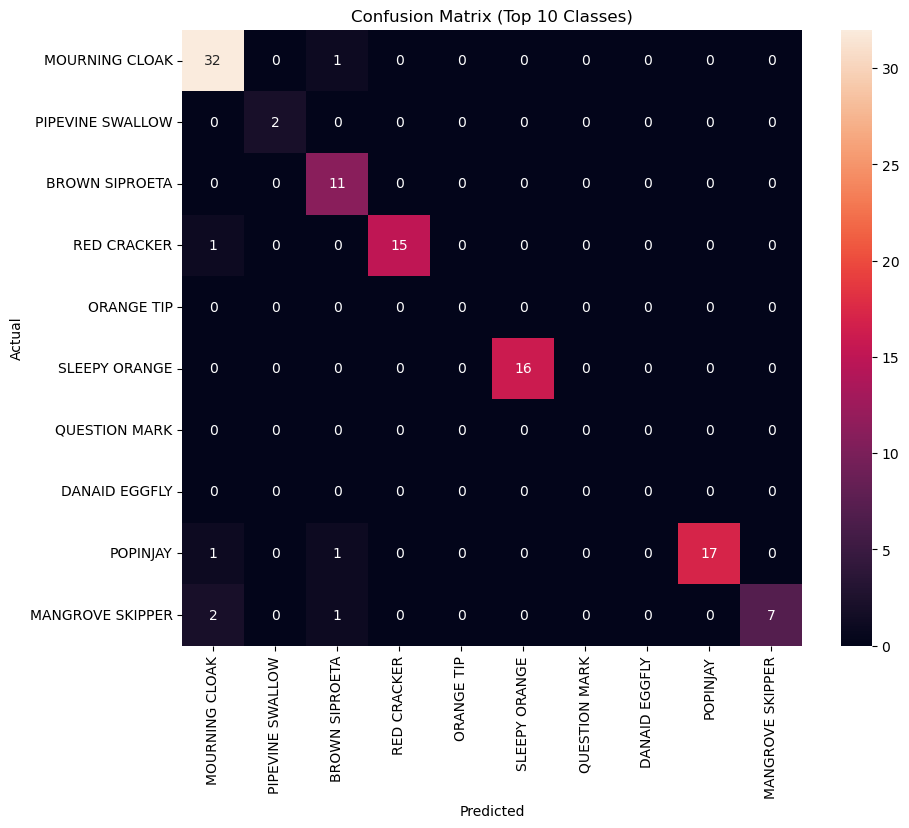

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=top10_labels, yticklabels=top10_labels)
plt.title("Confusion Matrix (Top 10 Classes)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [24]:
# Predict on test set (optional)
test_preds = model.predict(X_test)
test_class_indices = np.argmax(test_preds, axis=1)
test_labels = label_encoder.inverse_transform(test_class_indices)

88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step


In [25]:
# Save test predictions to CSV
test_csv['predicted_label'] = test_labels
test_csv.to_csv("Test_Predictions.csv", index=False)
print("\nTest predictions saved to Test_Predictions.csv")


Test predictions saved to Test_Predictions.csv
